In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import shap
import matplotlib.pyplot as plt
import warnings

# Debug warnings
warnings.filterwarnings('ignore', category=FutureWarning)
print("Libraries imported successfully.")


C:\Users\AFFAN\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully.


In [2]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
# Load datasets
tweets_data = pd.read_csv(r'C:\Users\AFFAN\dm stock pred\af stock test\cleaned_stock_tweets.csv')
stock_data = pd.read_csv(r'C:\Users\AFFAN\dm stock pred\af stock test\stock_data_1year_enriched.csv')

# Preview datasets
print("Tweets Data Sample:\n", tweets_data.head(), "\n")
print("Stock Data Sample:\n", stock_data.head(), "\n")


Tweets Data Sample:
                         Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  \
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.   
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.   
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.   
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.   
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.   

                                        cleaned_text  
0  mainstream media has done an amazing job at br...  
1  tesla delivery estimates are at around k from ...  
2  even if i include m unvested rsus as of  addit...  
3  hahaha why are you still trying to stop tesla ...  
4  stop trying to kill kids yo

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from tqdm import tqdm

# FinBERT Model Setup
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')

# Ensure 'cleaned_text' is a string and handle missing or invalid data
tweets_data['cleaned_text'] = tweets_data['cleaned_text'].astype(str).fillna("")
tweets_data = tweets_data[tweets_data['cleaned_text'].str.strip() != ""]  # Remove empty strings

# Define sentiment analysis function
def sentiment_analysis(text):
    # Tokenize the input text
    inputs = tokenizer(
        text, 
        return_tensors='pt', 
        truncation=True, 
        padding=True, 
        max_length=512
    ).to(device)
    
    # Get model predictions
    outputs = model(**inputs)
    scores = torch.nn.functional.softmax(outputs.logits, dim=1)
    sentiment = torch.argmax(scores).item()  # 0 = Negative, 1 = Neutral, 2 = Positive
    return sentiment, scores.tolist()

# Send FinBERT model to GPU
model.to(device)

# Batch-wise Sentiment Analysis for large datasets
batch_size = 32
sentiments = []
sentiment_scores = []

for i in tqdm(range(0, len(tweets_data), batch_size), desc="Processing Batches"):
    batch_texts = tweets_data['cleaned_text'][i:i + batch_size].tolist()
    batch_sentiments, batch_scores = zip(*[sentiment_analysis(text) for text in batch_texts])
    sentiments.extend(batch_sentiments)
    sentiment_scores.extend(batch_scores)

# Add results back to the dataframe
tweets_data['Sentiment'] = sentiments
tweets_data['Sentiment_Score'] = sentiment_scores
tweets_data.to_csv("cleaned_stock_tweets_with_sentiment.csv", index=False)
print("Sentiment analysis results saved.")




Processing Batches: 100%|██████████| 2525/2525 [10:05<00:00,  4.17it/s]


Sentiment analysis results saved.


In [6]:
print(tweets_data['Sentiment'].value_counts())


Sentiment
0    58454
1    14767
2     7572
Name: count, dtype: int64


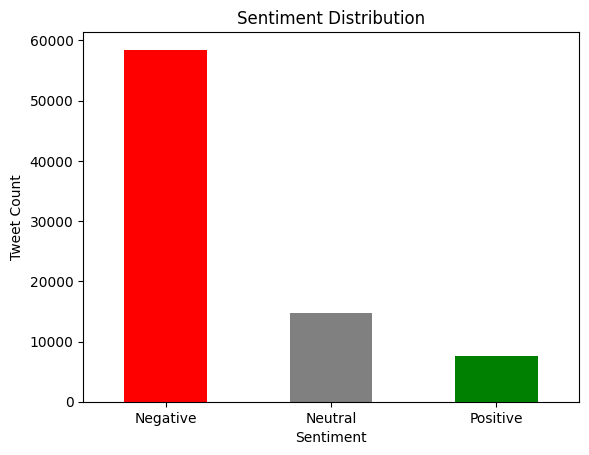

In [7]:
import matplotlib.pyplot as plt

tweets_data['Sentiment'].value_counts().plot(kind='bar', color=['red', 'gray', 'green'])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'], rotation=0)
plt.show()


In [8]:
for stock in ['TSLA', 'AAPL', 'AMZN', 'NVDA']:
    stock_tweets = tweets_data[tweets_data['Stock Name'] == stock]
    print(f"{stock} Sentiment Distribution:")
    print(stock_tweets['Sentiment'].value_counts())


TSLA Sentiment Distribution:
Sentiment
0    27022
1     6705
2     3695
Name: count, dtype: int64
AAPL Sentiment Distribution:
Sentiment
0    3638
1     866
2     552
Name: count, dtype: int64
AMZN Sentiment Distribution:
Sentiment
0    2857
1     765
2     467
Name: count, dtype: int64
NVDA Sentiment Distribution:
Series([], Name: count, dtype: int64)


In [9]:
# Create separate DataFrames for each stock
stock_dataframes = {stock: stock_data[stock_data['Stock'] == stock].reset_index(drop=True) for stock in ['TSLA', 'AAPL', 'AMZN', 'NVDA']}

# Print the number of rows for each stock
for stock, data in stock_dataframes.items():
    print(f"{stock}: {len(data)} rows loaded.")


TSLA: 252 rows loaded.
AAPL: 252 rows loaded.
AMZN: 252 rows loaded.
NVDA: 252 rows loaded.


In [10]:
print("Invalid dates in tweets_data:")
print(tweets_data[pd.to_datetime(tweets_data['Date'], errors='coerce').isna()])

for stock, data in stock_dataframes.items():
    print(f"Invalid dates in {stock}:")
    print(data[pd.to_datetime(data['Date'], errors='coerce').isna()])


Invalid dates in tweets_data:
Empty DataFrame
Columns: [Date, Tweet, Stock Name, Company Name, cleaned_text, Sentiment, Sentiment_Score]
Index: []
Invalid dates in TSLA:
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, Dividends, Stock Splits, Stock, RSI, MA20, MA50, UpperBand, MiddleBand, LowerBand]
Index: []
Invalid dates in AAPL:
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, Dividends, Stock Splits, Stock, RSI, MA20, MA50, UpperBand, MiddleBand, LowerBand]
Index: []
Invalid dates in AMZN:
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, Dividends, Stock Splits, Stock, RSI, MA20, MA50, UpperBand, MiddleBand, LowerBand]
Index: []
Invalid dates in NVDA:
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume, Dividends, Stock Splits, Stock, RSI, MA20, MA50, UpperBand, MiddleBand, LowerBand]
Index: []


In [11]:
# Define the relevant stock names
relevant_stocks = ['TSLA', 'AAPL', 'AMZN', 'NVDA']

# Filter tweets to include only relevant stocks
tweets_data_filtered = tweets_data[tweets_data['Stock Name'].isin(relevant_stocks)]

# Print the number of rows before and after filtering
print(f"Original tweets data size: {len(tweets_data)} rows")
print(f"Filtered tweets data size: {len(tweets_data_filtered)} rows")


Original tweets data size: 80793 rows
Filtered tweets data size: 46567 rows


In [14]:
# Check the data type and first few rows of the 'Date' column in tweets_data_filtered
print("Tweets Data - 'Date' Column:")
print(tweets_data_filtered['Date'].head())
print("Data Type:", tweets_data_filtered['Date'].dtype)

# Check the data type and first few rows of the 'Date' column for each stock in stock_dataframes
for stock, data in stock_dataframes.items():
    print(f"\nStock: {stock} - 'Date' Column:")
    print(data['Date'].head())
    print("Data Type:", data['Date'].dtype)


Tweets Data - 'Date' Column:
0    2022-09-29 23:41:16+00:00
1    2022-09-29 23:24:43+00:00
2    2022-09-29 23:18:08+00:00
3    2022-09-29 22:40:07+00:00
4    2022-09-29 22:27:05+00:00
Name: Date, dtype: object
Data Type: object

Stock: TSLA - 'Date' Column:
0    2021-09-01 00:00:00-04:00
1    2021-09-02 00:00:00-04:00
2    2021-09-03 00:00:00-04:00
3    2021-09-07 00:00:00-04:00
4    2021-09-08 00:00:00-04:00
Name: Date, dtype: object
Data Type: object

Stock: AAPL - 'Date' Column:
0    2021-09-01 00:00:00-04:00
1    2021-09-02 00:00:00-04:00
2    2021-09-03 00:00:00-04:00
3    2021-09-07 00:00:00-04:00
4    2021-09-08 00:00:00-04:00
Name: Date, dtype: object
Data Type: object

Stock: AMZN - 'Date' Column:
0    2021-09-01 00:00:00-04:00
1    2021-09-02 00:00:00-04:00
2    2021-09-03 00:00:00-04:00
3    2021-09-07 00:00:00-04:00
4    2021-09-08 00:00:00-04:00
Name: Date, dtype: object
Data Type: object

Stock: NVDA - 'Date' Column:
0    2021-09-01 00:00:00-04:00
1    2021-09-02 00:00:00

In [16]:
for stock, data in stock_dataframes.items():
    print(f"Stock: {stock} - 'Date' Column:")
    print(data['Date'].head())
    print(data['Date'].dtype)


Stock: TSLA - 'Date' Column:
0    2021-09-01
1    2021-09-02
2    2021-09-03
3    2021-09-07
4    2021-09-08
Name: Date, dtype: object
object
Stock: AAPL - 'Date' Column:
0    2021-09-01 00:00:00-04:00
1    2021-09-02 00:00:00-04:00
2    2021-09-03 00:00:00-04:00
3    2021-09-07 00:00:00-04:00
4    2021-09-08 00:00:00-04:00
Name: Date, dtype: object
object
Stock: AMZN - 'Date' Column:
0    2021-09-01 00:00:00-04:00
1    2021-09-02 00:00:00-04:00
2    2021-09-03 00:00:00-04:00
3    2021-09-07 00:00:00-04:00
4    2021-09-08 00:00:00-04:00
Name: Date, dtype: object
object
Stock: NVDA - 'Date' Column:
0    2021-09-01 00:00:00-04:00
1    2021-09-02 00:00:00-04:00
2    2021-09-03 00:00:00-04:00
3    2021-09-07 00:00:00-04:00
4    2021-09-08 00:00:00-04:00
Name: Date, dtype: object
object


In [20]:
# Define the relevant stocks (excluding Nvidia)
relevant_stocks = ['TSLA', 'AAPL', 'AMZN']

# Filter tweets data to include only relevant stocks
tweets_data_filtered = tweets_data[tweets_data['Stock Name'].isin(relevant_stocks)].copy()

# Ensure 'Date' column in tweets_data_filtered is properly converted to datetime
tweets_data_filtered['Date'] = pd.to_datetime(tweets_data_filtered['Date'], errors='coerce')
tweets_data_filtered = tweets_data_filtered.dropna(subset=['Date'])  # Drop invalid dates
tweets_data_filtered['Date'] = tweets_data_filtered['Date'].dt.tz_localize(None)  # Remove timezone information
tweets_data_filtered['Date'] = tweets_data_filtered['Date'].dt.date  # Extract only the date

# Create stock-specific DataFrames for Tesla, Apple, and Amazon
stock_dataframes = {stock: stock_data[stock_data['Stock'] == stock].reset_index(drop=True) for stock in relevant_stocks}

# Ensure 'Date' column in stock_dataframes is properly converted to datetime
for stock, data in stock_dataframes.items():
    print(f"Processing stock: {stock}")
    
    # Convert 'Date' to datetime, handle errors, and remove timezone
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')  # Convert to datetime
    data = data.dropna(subset=['Date'])  # Drop invalid dates

    # Check if the column is datetimelike
    if not pd.api.types.is_datetime64_any_dtype(data['Date']):
        print(f"Error: 'Date' column in {stock} is not datetime-like after conversion.")
        continue

    # Remove timezone information if present
    data['Date'] = data['Date'].dt.tz_localize(None)  # Remove timezone

    # Extract only the date part
    data['Date'] = data['Date'].dt.date

    # Update the stock dataframe
    stock_dataframes[stock] = data

# Initialize dictionary to store merged data for each stock
merged_dataframes = {}

# Merge each stock DataFrame with the filtered tweets data
for stock, stock_df in stock_dataframes.items():
    print(f"Processing stock: {stock}")
    
    # Filter tweets for the current stock
    tweets_subset = tweets_data_filtered[tweets_data_filtered['Stock Name'] == stock]
    
    # Merge datasets
    merged_data = pd.merge(stock_df, tweets_subset, on='Date', how='left')

    # Fill missing sentiment data with 0
    merged_data['Sentiment'] = merged_data['Sentiment'].fillna(0)
    merged_data['Sentiment_Score'] = merged_data['Sentiment_Score'].fillna(0)
    merged_data['Volume_Weighted_Sentiment'] = merged_data['Sentiment_Score'] * merged_data['Volume']
    merged_data = merged_data.fillna(0)  # Fill other missing values with 0

    # Store merged data in the dictionary
    merged_dataframes[stock] = merged_data
    print(f"{stock}: Merged dataset has {len(merged_data)} rows.")

# Verify the output
for stock, data in merged_dataframes.items():
    print(f"{stock} sample rows:")
    print(data.head())


Processing stock: TSLA
Error: 'Date' column in TSLA is not datetime-like after conversion.
Processing stock: AAPL
Error: 'Date' column in AAPL is not datetime-like after conversion.
Processing stock: AMZN
Error: 'Date' column in AMZN is not datetime-like after conversion.
Processing stock: TSLA
TSLA: Merged dataset has 252 rows.
Processing stock: AAPL
AAPL: Merged dataset has 252 rows.
Processing stock: AMZN
AMZN: Merged dataset has 252 rows.
TSLA sample rows:
                        Date        Open        High         Low       Close  \
0  2021-09-01 00:00:00-04:00  244.693329  247.330002  243.756668  244.696671   
1  2021-09-02 00:00:00-04:00  244.833328  246.990005  243.513336  244.130005   
2  2021-09-03 00:00:00-04:00  244.083328  244.666672  241.399994  244.523331   
3  2021-09-07 00:00:00-04:00  246.666672  253.399994  246.419998  250.973328   
4  2021-09-08 00:00:00-04:00  253.860001  254.816666  246.923340  251.289993   

     Volume  Dividends  Stock Splits Stock  RSI  ...  

In [21]:
import os

# Directory to save merged files
save_dir = "merged_stock_data"
os.makedirs(save_dir, exist_ok=True)

# Save each merged DataFrame to a CSV file
for stock, data in merged_dataframes.items():
    file_path = os.path.join(save_dir, f"{stock}_merged_data.csv")
    data.to_csv(file_path, index=False)
    print(f"Merged data for {stock} saved to {file_path}.")


Merged data for TSLA saved to merged_stock_data\TSLA_merged_data.csv.
Merged data for AAPL saved to merged_stock_data\AAPL_merged_data.csv.
Merged data for AMZN saved to merged_stock_data\AMZN_merged_data.csv.
